In [1]:
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.flasso.Replicate import Replicate
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel
from codes.otherfunctions.get_grads import get_grads3
from codes.experimentclasses.RigidEthanolPCA3 import get_rigid_ethanol_data
from codes.otherfunctions.get_cosines import get_cosines

n = 10000  # number of data points to simulate
nsel = 100  # number of points to analyze with lasso
n_neighbors = 1000  # number of neighbors in megaman
m = 3  # number of embedding dimensions (diffusion maps)
diffusion_time = 0.05  # embedding radius
dim = 2  # manifold dimension
dimnoise = 2  # manifold dimension (not in mflasso paper)
cores = 3
nreps = 1
natoms = 9
ii = np.asarray([0, 0, 0, 0, 1, 1, 1, 2])  # atom adjacencies for dihedral angle computation
jj = np.asarray([1, 2, 3, 4, 5, 6, 7, 8])

savename = 'rigidethanol_021521'
savefolder = 'rigidethanol'
# loadfolder = 'rigidethanol'
# loadname = 'ethanol_021521'
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

folder = workingdirectory + '/Figures/rigidethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)
experiment = AtomicRegression(natoms)
experiment.m = m
experiment.dim = dim
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.atoms3, experiment.da = experiment.get_atoms_3()
experiment.atoms4, experiment.p = get_atoms_4(natoms, ii, jj)

data, experiment.positions = get_rigid_ethanol_data(cor=0., xvar=0., cores=3, atoms3=experiment.atoms3, noise=False)

experiment.M = RiemannianManifold(data, dim)  # experiment.load_data(workingdirectory = data_wd)
experiment.svd = TruncatedSVD(n_components=50)
experiment.Mpca = RiemannianManifold(experiment.svd.fit_transform(experiment.M.data), dim)
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)


/Users/samsonkoelle/manifoldflasso_jmlr


In [2]:
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)


In [3]:
from codes.otherfunctions.get_dictionaries import get_all_atoms_4

In [4]:
experiment.atoms4,experiment.p = get_all_atoms_4(natoms)


In [14]:
def torchComputeAngle(poses):
    combos = torch.tensor([[0, 1], [1, 2], [2, 0]])
    ab = torch.norm(poses[combos[0, 0], :] - poses[combos[0, 1], :])
    bc = torch.norm(poses[combos[1, 0], :] - poses[combos[1, 1], :])
    ca = torch.norm(poses[combos[2, 0], :] - poses[combos[2, 1], :])
    output = torch.acos((ab ** 2 - bc ** 2 + ca ** 2) / (2 * ab * ca))
    return (output)

def torchCompute3angles(position):
    angles = np.ones(3)
    gradients = np.zeros((3, position.shape[0], 3))
    for i in range(3):
        #print(i)
        poses = torch.tensor(position[[i, (i + 1) % 3, (i + 2) % 3], :], requires_grad=True)
        tempang = torchComputeAngle(poses)
        tempang.backward()
        angles[i] = tempang.detach().numpy()
        gradients[i] = poses.grad[[(2 * i) % 3, (2 * i + 1) % 3, (2 * i + 2) % 3], :]
        # del(poses)
    return(angles, gradients)

def reshapepointdata( pointdata, atoms3):
    natoms = len(np.unique(atoms3))
    output = np.zeros((pointdata.shape[0] * pointdata.shape[1], natoms * 3))
    for i in range(pointdata.shape[0]):
        for j in range(pointdata.shape[1]):
            for k in range(pointdata.shape[2]):
                for l in range(pointdata.shape[3]):
                    # print(atoms3[k]*3 + l)
                    output[i * 3 + j, atoms3[i][k] * 3 + l] = pointdata[i, j, k, l]
    return(output)

def get_wilson( selind, atoms3, tdata):
    natoms = len(np.unique(atoms3))
    jacobien = np.zeros((len(selind), len(atoms3) * 3, natoms * 3))
    for i in range(len(selind)):
        pointdata = tdata[i * len(atoms3): (i + 1) * len(atoms3)]
        jacobien[i] = reshapepointdata(pointdata, atoms3)
    return(jacobien)

def get_deformation_projector( natoms, jacobien, selind):
    nnonzerosvd = 3 * natoms - 7
    deformation = np.zeros((len(selind),  nnonzerosvd))
    for i in range(len(selind)):
        asdf = np.linalg.svd(jacobien[i])
        deformation[i] = (asdf[1][:nnonzerosvd] )
    return (deformation)

def get_dw(cores,atoms3,natoms, selected_points,positions):
    positions = positions
    selected_points = selected_points
    p = Pool(cores)
    n = len(selected_points)
    results = p.map(lambda i: torchCompute3angles(position=positions[i[0], atoms3[i[1]], :]),
                    data_stream_custom_range(selected_points, len(atoms3)))
    tdata = np.asarray([results[i][1] for i in range(n * len(atoms3))])
    # for i in range(len(selected_points)):
    #     pointdata = tdata[i * len(atoms3): (i + 1) * len(atoms3)]
    jacobien = get_wilson(selected_points, atoms3, tdata)
    deformation = get_deformation_projector(natoms, jacobien, selected_points)
    return(deformation)

In [6]:
import torch
from pathos.multiprocessing import ProcessingPool as Pool
from codes.otherfunctions.data_stream_custom_range import data_stream_custom_range


NameError: name 'replicates' is not defined

In [8]:
print('pre-gradient acquisition', datetime.datetime.now())
replicates = {}
nsel = 5
for i in range(1):
    replicates[i] = Replicate(nsel=nsel, n=experiment.M.data.shape[0])
    replicates[i].df_M, replicates[i].dg_M, replicates[i].dg_w, replicates[i].dg_w_pca, replicates[i].dgw_norm, \
    replicates[i].tangent_bases = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N,
                                             replicates[i].selected_points, experiment.svd)


pre-gradient acquisition 2021-06-06 21:36:13.115975


In [15]:
np.linalg.svd(replicates[i].dg_M[0])[1]

array([33.22629828,  6.40009585])

In [17]:
get_dw(cores,experiment.atoms3,9, replicates[i].selected_points, experiment.positions)

array([[5.27854331, 4.9247771 , 4.16511026, 3.97049902, 3.66468324,
        3.55561383, 3.49431613, 2.84144791, 2.81846368, 2.78780446,
        2.18668256, 2.11318989, 1.51637788, 1.13604895, 0.70501972,
        0.57262143, 0.54408576, 0.52809424, 0.46189059, 0.41427587],
       [4.90231903, 4.86602524, 4.18540651, 3.96386979, 3.66141746,
        3.54642701, 3.47210433, 2.86919967, 2.82416297, 2.77857064,
        2.20419652, 2.13633994, 2.11956078, 1.52213902, 1.16593001,
        0.68339254, 0.55823769, 0.47615326, 0.46502962, 0.42583582],
       [4.90094284, 4.88124494, 4.18612794, 3.90656639, 3.66486785,
        3.61785448, 3.57567041, 2.91633296, 2.81978859, 2.65891734,
        2.17728618, 2.09922203, 1.99323743, 1.52262663, 1.26393362,
        0.68017521, 0.55946399, 0.47888959, 0.46799907, 0.42978635],
       [4.90597469, 4.88435496, 4.18211518, 3.95030695, 3.66017765,
        3.56237636, 3.4735966 , 2.8617476 , 2.82528904, 2.78534794,
        2.21914611, 2.10136664, 2.08904978, 1

In [18]:
import numpy as np

In [19]:
asdf = np.array([[5.27854331, 4.9247771 , 4.16511026, 3.97049902, 3.66468324,
        3.55561383, 3.49431613, 2.84144791, 2.81846368, 2.78780446,
        2.18668256, 2.11318989, 1.51637788, 1.13604895, 0.70501972,
        0.57262143, 0.54408576, 0.52809424, 0.46189059, 0.41427587],
       [4.90231903, 4.86602524, 4.18540651, 3.96386979, 3.66141746,
        3.54642701, 3.47210433, 2.86919967, 2.82416297, 2.77857064,
        2.20419652, 2.13633994, 2.11956078, 1.52213902, 1.16593001,
        0.68339254, 0.55823769, 0.47615326, 0.46502962, 0.42583582],
       [4.90094284, 4.88124494, 4.18612794, 3.90656639, 3.66486785,
        3.61785448, 3.57567041, 2.91633296, 2.81978859, 2.65891734,
        2.17728618, 2.09922203, 1.99323743, 1.52262663, 1.26393362,
        0.68017521, 0.55946399, 0.47888959, 0.46799907, 0.42978635],
       [4.90597469, 4.88435496, 4.18211518, 3.95030695, 3.66017765,
        3.56237636, 3.4735966 , 2.8617476 , 2.82528904, 2.78534794,
        2.21914611, 2.10136664, 2.08904978, 1.52150591, 1.17176204,
        0.6852194 , 0.55826719, 0.47852439, 0.46428953, 0.42090922],
       [5.22550376, 4.92398695, 4.16561744, 3.9454855 , 3.66431151,
        3.58338344, 3.47829848, 2.84412792, 2.81853284, 2.78938091,
        2.23440983, 2.0583956 , 1.51695789, 1.18330039, 0.95338072,
        0.68577064, 0.54780313, 0.52529981, 0.46162361, 0.41140926]])

Text(0.5, 0, 'Singular values of Angular Metric versus Euclidean')

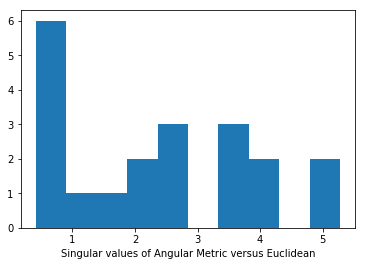

In [24]:
plt.hist(asdf[0])
plt.xlabel('Singular values of Angular Metric versus Euclidean')

In [21]:
import matplotlib.pyplot as plt